In [1]:
%load_ext autoreload

In [2]:
%autoreload
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

sys.path.append('../src/')
from indicators import *

%matplotlib inline

Read a dataframe that has only EU organisations and includes:
* People working in the EU
* Their degrees, job, ethnicity, gender

In [3]:
df = pd.read_csv('../data/processed/ojpd_eu.csv')

In [4]:
df['founded_on'] = df.founded_on.apply(lambda x: x[:4] if isinstance(x, str) else x)

## Very basic EDA

In [5]:
# Missing values
df.isnull().sum() / df.shape[0]

org_id                 0.000000
funding_total_usd      0.557702
founded_on             0.046653
city                   0.000000
country                0.000000
employee_count         0.112658
primary_role           0.000000
org_id.1               0.000000
job_id                 0.000000
is_current             0.000000
job_type               0.000000
category_group_list    0.083661
person_id              0.000000
first_name             0.000000
last_name              0.000000
gender                 0.023831
race                   0.000000
degree_type            0.599835
degree_id              0.539614
institution_id         0.539614
dtype: float64

In [6]:
print('NUMBER OF UNIQUE EU COMPANIES: {}'.format(df.org_id.unique().shape[0]))
print('NUMBER OF UNIQUE WORKERS IN EU COMPANIES: {}'.format(df.person_id.unique().shape[0]))

NUMBER OF UNIQUE EU COMPANIES: 57277
NUMBER OF UNIQUE WORKERS IN EU COMPANIES: 172498


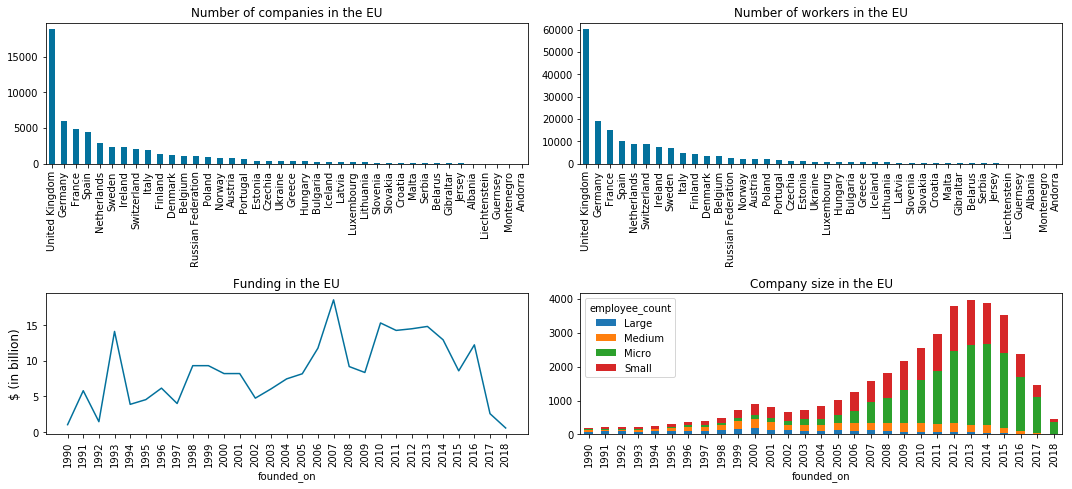

In [7]:
f = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3, 2)

# ax1
ax1 = plt.subplot(gs[0, :1])
df.drop_duplicates('org_id').country.value_counts().plot(kind='bar', color='xkcd:ocean blue', ax=ax1)
ax1.set_title('Number of companies in the EU', fontsize=12)

# ax2
ax2 = plt.subplot(gs[0, 1:])
df.drop_duplicates('person_id').country.value_counts().plot(kind='bar', color='xkcd:ocean blue', ax=ax2)
ax2.set_title('Number of workers in the EU', fontsize=12)

# ax3
ax3 = plt.subplot(gs[1, :1])
funding = df.drop_duplicates('org_id').groupby('founded_on').sum()['funding_total_usd'].loc['1990':, ] / 1000000000
funding.plot(color='xkcd:ocean blue', ax=ax3)
ax3.set_xticks(range(len(funding.index)))
ax3.set_xticklabels(list(funding.index), rotation=90)
ax3.set_title('Funding in the EU', fontsize=12)
ax3.set_ylabel('$ (in billion)', fontsize=12) 

# ax4
ax4 = plt.subplot(gs[1, 1:])
comp_size = df.drop_duplicates('org_id').groupby(['founded_on', 'employee_count']).count()['org_id'].loc['1990':, ]
comp_size.unstack('employee_count').plot(kind='bar', stacked=True, ax=ax4)
ax4.set_xticks(range(len(comp_size.unstack('employee_count').index)))
ax4.set_xticklabels(list(comp_size.unstack('employee_count').index), rotation=90)
ax4.set_title('Company size in the EU', fontsize=12)

plt.tight_layout()
plt.show()

## Indicators

In [8]:
# # 3. Gender distribution for degrees
# degree_gender = ind.people_diversity('degree_type', 'gender')

# # 4. Ethnic distribution for degrees
# degree_ethnicity = ind.people_diversity('degree_type', 'race')

# # 5. Degree distribution for women/men
# gender_degree = ind.people_diversity('gender', 'degree_type')
# gender_degree = gender_degree.where(gender_degree > 0.02).dropna()

# # 6. Degree distribution for ethnic groups
# ethnicity_degree = ind.people_diversity('race', 'degree_type')
# ethnicity_degree = ethnicity_degree.where(ethnicity_degree > 0.02).dropna()

ind = Indicators(df)

# 1. Gender diversity (city level)
country_gender = ind.people_diversity('country', 'gender')

# 2. Ethnic diversity (city level)
country_ethnicity = ind.people_diversity('country', 'race')

# 7. Gender diversity in roles (city level)
role_comp_gender = ind.city_role_company('country', 'job_type', 'gender')

# 8. Ethnic diversity in roles (city level)
role_comp_ethnicity = ind.city_role_company('country', 'job_type', 'race')

# 9. Gender diversity in categories (city level)
cat_comp_gender = ind.city_role_company('country', 'category_group_list', 'gender')

# 10. Ethnic diversity in categories (city level)
cat_comp_ethnicity = ind.city_role_company('country', 'category_group_list', 'race')

# 11. Gender diversity in categories
cat_gender = ind.city_role_company('category_group_list', 'gender')

# 12. Ethnic diversity in categories
cat_ethnicity = ind.city_role_company('category_group_list', 'race')

# 13. Lieberson index (intersectionality) - city level
data_formatting = ind.lieberson_format(['gender', 'race'], city_level=True, country='Germany')
lieberson_index_cities = {k:ind.lieberson_index(v) for k, v in data_formatting.items()}

# 14. Lieberson index (intersectionality) - country level
data_formatting = ind.lieberson_format(['gender', 'race'], country_level=True)
lieberson_index_countries = {k:ind.lieberson_index(v) for k, v in data_formatting.items()}

# Visualisation

### Indicators 1 & 2

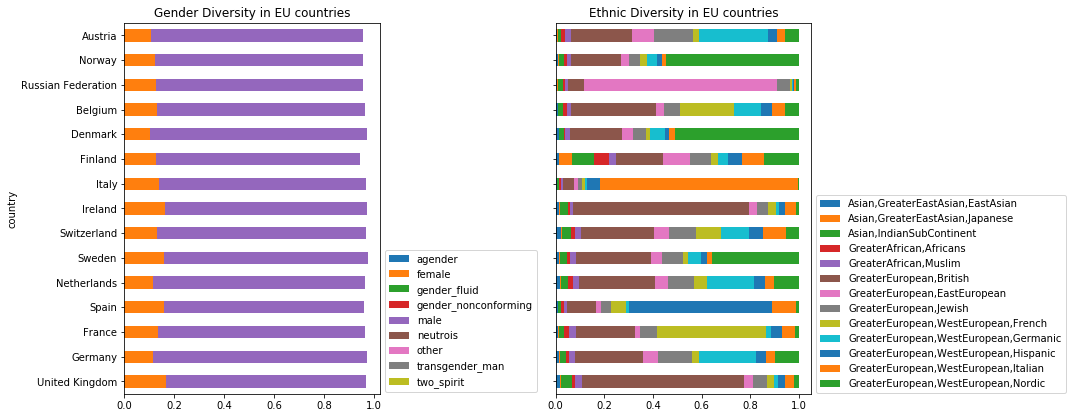

In [9]:
f = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2)

# ax1
ax1 = plt.subplot(gs[0, 0])
country_gender.unstack('gender').iloc[:15].plot(kind='barh', stacked=True, ax=ax1, legend=False)
ax1.set_title('Gender Diversity in EU countries', fontsize=12)
ax1.legend(bbox_to_anchor=(1, 0.4))

# ax2
ax2 = plt.subplot(gs[0, 1])
country_ethnicity.unstack('race').iloc[:15].plot(kind='barh', stacked=True, ax=ax2)
ax2.set_title('Ethnic Diversity in EU countries', fontsize=12)
ax2.set_yticklabels([])
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1, 0.55))

plt.tight_layout()
plt.show()

### Indicators 11 & 12

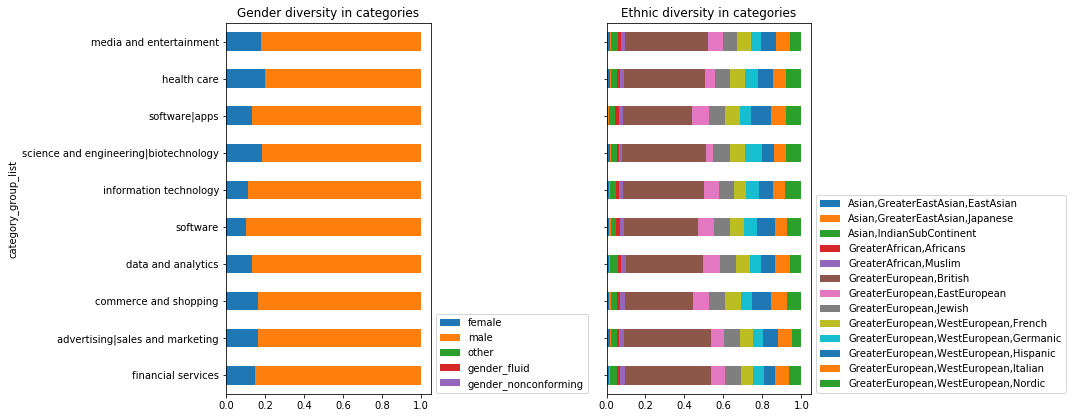

In [10]:
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1,2)
idx = cat_gender.groupby('category_group_list').sum().sort_values(ascending=False).index
i = pd.IndexSlice
# ax1
ax1 = plt.subplot(gs[0,0])
cg = cat_gender / cat_gender.groupby('category_group_list').sum()
cg.reindex(idx, level=0).loc[i[idx[:10], :], ].unstack().plot(kind='barh', stacked=True, ax=ax1)
ax1.set_title('Gender diversity in categories', fontsize=12)
ax1.legend(bbox_to_anchor=(1, 0.23))

# ax2
ax2 = plt.subplot(gs[0,1])
ce = cat_ethnicity / cat_ethnicity.groupby('category_group_list').sum()
ce.reindex(idx, level=0).loc[i[idx[:10], :], ].unstack().plot(kind='barh', stacked=True, ax=ax2)
ax2.set_title('Ethnic diversity in categories', fontsize=12)
ax2.set_yticklabels([])
ax2.set_ylabel('')
ax2.legend(bbox_to_anchor=(1, 0.55))

plt.tight_layout()
plt.show()

### Indicators 13 & 14

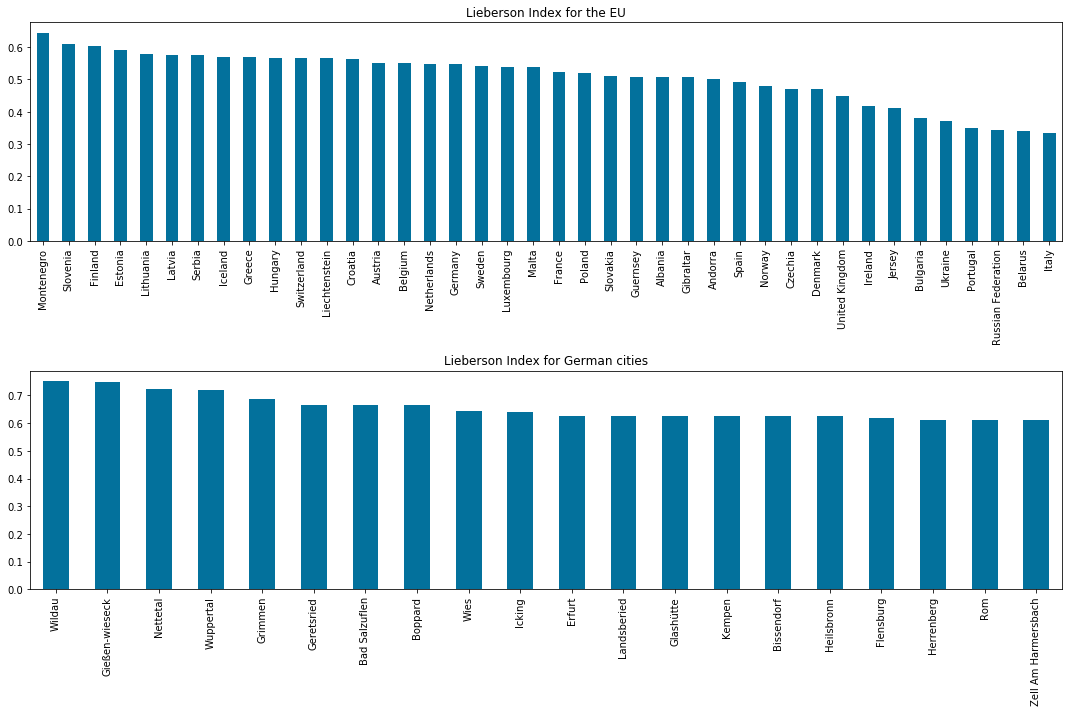

In [12]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2,1)

ax1 = plt.subplot(gs[0,:])
pd.DataFrame.from_dict(lieberson_index_countries, orient='index').sort_values(0, ascending=False).plot(kind='bar', ax=ax1, color='xkcd:ocean blue', legend=False)
ax1.set_title('Lieberson Index for the EU', fontsize=12)

ax2 = plt.subplot(gs[1,:])
pd.DataFrame.from_dict(lieberson_index_cities, orient='index').sort_values(0, ascending=False)[:20].plot(kind='bar', ax=ax2, color='xkcd:ocean blue', legend=False)
ax2.set_title('Lieberson Index for German cities', fontsize=12)

plt.tight_layout()
plt.show()